# FENE beadspring with variable kuhn length experiment data analysis

In [1]:
import os

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.data_analysis.data.constants as data_constants
import polyflexmd.data_analysis.pipelines.trajectory as pipeline_process
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
import scipy.optimize
import functools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style("darkgrid")

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Read and process data

In [53]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212"
NAME_EC = "4-FENE-beadspring-vary-l_K.toml"
EQUILIBRIUM_ONLY = False
CONTINUE = True
CONTINUE_t_equilibrium = 58000000
N_WORKERS = 16
CHECK_BOND_LENGTHS = False

In [54]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
EQUILIBRIUM_ONLY = bool(EQUILIBRIUM_ONLY)
CHECK_BOND_LENGTHS = bool(CHECK_BOND_LENGTHS)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC
N_WORKERS = int(N_WORKERS)

In [55]:
pandarallel.initialize(
    nb_workers=N_WORKERS,
    progress_bar=False,
    use_memory_fs=None
)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read experiment config

In [56]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='72:00:00', partition='romeo', nodes=8, tasks_per_node=128, ntasks=1024, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=8, n_tasks_per_partition=128, variables={'kappa_start': 1.0, 'kappa_delta': 5, 'kappa_n_values': 8, 'n_relax_steps': 33000000, 'n_equilibrium_steps': 10000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=4, mem_per_cpu=1000), venv_path=PosixPath('/scratch/ws/0/s461

In [57]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 6.0, 11.0, 16.0, 21.0, 26.0, 31.0, 36.0]

### Read initial system

In [58]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,-0.159927,-0.017451,-0.956566,0,0,0
3,1,2,-0.086992,-0.765936,-0.343908,0,0,0
4,1,2,0.059319,0.029401,-0.879569,0,0,0
5,1,2,0.514538,0.823298,-0.558005,0,0,0
...,...,...,...,...,...,...,...,...
25596,200,2,-10.247604,-9.443705,1.107040,0,0,0
25597,200,2,-10.923059,-9.000052,1.643541,0,0,0
25598,200,2,-10.288177,-8.437497,1.173056,0,0,0
25599,200,2,-10.067385,-8.446238,2.117553,0,0,0


In [59]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
25396,1,25595,25596
25397,1,25596,25597
25398,1,25597,25598
25399,1,25598,25599


In [60]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
25196,1,25594,25595,25596
25197,1,25595,25596,25597
25198,1,25596,25597,25598
25199,1,25597,25598,25599


In [61]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Extract main-axis dataframe

In [62]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED.mkdir(exist_ok=True, parents=True)
PATH_DATA_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212/data/processed/continue')

In [63]:
PATH_DF_MAIN_AXIS = PATH_DATA_PROCESSED / "main_axis.csv"
if PATH_DF_MAIN_AXIS.exists():
    df_main_axis = pd.read_csv(PATH_DF_MAIN_AXIS)
else:
    df_main_axis = transform.unfold_coordinates_df(system.atoms, system).groupby("molecule-ID").head(n=2)
    df_main_axis.to_csv(PATH_DF_MAIN_AXIS, index=False)
df_main_axis

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,-0.159927,-0.017451,-0.956566,0,0,0
129,2,1,0.000000,0.000000,0.000000,0,0,0
130,2,1,-0.682228,-0.434785,-0.535188,0,0,0
257,3,1,0.000000,0.000000,0.000000,0,0,0
...,...,...,...,...,...,...,...,...
25218,198,1,-0.127358,0.770208,-0.575725,0,0,0
25345,199,1,0.000000,0.000000,0.000000,0,0,0
25346,199,1,-0.072379,-0.064582,0.965138,0,0,0
25473,200,1,0.000000,0.000000,0.000000,0,0,0


### Read and process trajectories

In [66]:
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectory_unfolded_kappas.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212/data/processed/continue/trajectory_unfolded_kappas.csv')

In [67]:
if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas = pd.read_csv(
        PATH_DF_TRAJECTORY_PROCESSED,
        dtype={
            **data_constants.RAW_TRAJECTORY_DF_COLUMN_TYPES,
            "molecule-ID": np.ushort,
            "kappa": "category",
        }
    )
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas = pipeline_process.read_and_process_trajectories(
        trajectories=read.get_experiment_trajectories_paths(
            experiment_raw_data_path=PATH_EXPERIMENT / "data",
            style="l_K",
            kappas=kappas,
            continue_=CONTINUE,
            read_relax=not EQUILIBRIUM_ONLY
        ),
        system=system
    )
    print("Writing...")
    df_trajectory_unfolded_kappas.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas

Reading processed...


,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
0,43000000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
1,43000000,2,1,-0.159927,-0.017451,-0.956566,0,0,0,1,1.0
2,43000000,3,2,-0.701293,0.727540,-1.291590,0,0,0,1,1.0
3,43000000,4,2,-1.130620,0.763959,-2.170250,0,0,0,1,1.0
4,43000000,5,2,-0.835501,1.059710,-1.273150,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
338329595,73000000,25596,2,-10.385500,-62.418301,-40.259701,0,0,0,200,36.0
338329596,73000000,25597,2,-10.388300,-63.451401,-40.145500,0,0,0,200,36.0
338329597,73000000,25598,2,-10.585800,-64.320000,-39.889900,0,0,0,200,36.0
338329598,73000000,25599,2,-10.851100,-65.139801,-39.646099,0,0,0,200,36.0


In [68]:
df_trajectory_unfolded_kappas.groupby(["kappa"])["t"].describe()

,count,mean,std,min,25%,50%,75%,max
kappa,,,,,,,,
1.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
6.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
11.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
16.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
21.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
26.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
31.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
36.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0


## Calculate and plot observables relax+equi

In [69]:
l_b_src = .97
L_src = l_b_src*(conf.initial_system_config.system_config.n_monomers-1)
L_src

123.19

### End-to-End distance $\vec{R}$

In [70]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "molecule-ID", "t"])
else:
    print("Processing...")
    df_ete = transform.calc_end_to_end_df(df_trajectory_unfolded_kappas, group_by_params=["kappa"], parallel=True)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Reading processed...


R_x        R_y       R_z          R
kappa molecule-ID t                                                  
1.0   1           43000000   0.776292  -7.756560  -4.01698   8.769434
                  43100000  14.942900  -8.777460 -12.44610  21.336342
                  43200000   8.072580  -3.591510  -7.73194  11.740885
                  43300000  -2.883810  -1.662700  -5.75536   6.648692
                  43400000   5.961520   0.210006  -7.21247   9.359677
...                               ...        ...       ...        ...
36.0  200         72960000 -13.669800 -58.464600 -44.21120  74.562746
                  72970000 -17.080400 -61.247900 -46.43560  78.735699
                  72980000 -17.119400 -63.686400 -44.13480  79.353084
                  72990000 -18.501500 -62.813600 -44.44030  79.137817
                  73000000 -10.890900 -66.065100 -39.44010  77.709270

[2641600 rows x 4 columns]

In [71]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x        R_y       R_z          R  \
kappa molecule-ID t                                                     
1.0   1           43000000   0.776292  -7.756560  -4.01698   8.769434   
                  43100000  14.942900  -8.777460 -12.44610  21.336342   
                  43200000   8.072580  -3.591510  -7.73194  11.740885   
                  43300000  -2.883810  -1.662700  -5.75536   6.648692   
                  43400000   5.961520   0.210006  -7.21247   9.359677   
...                               ...        ...       ...        ...   
36.0  200         72960000 -13.669800 -58.464600 -44.21120  74.562746   
                  72970000 -17.080400 -61.247900 -46.43560  78.735699   
                  72980000 -17.119400 -63.686400 -44.13480  79.353084   
                  72990000 -18.501500 -62.813600 -44.44030  79.137817   
                  73000000 -10.890900 -66.065100 -39.44010  77.709270   

                                t/LJ          R^2  
kappa molecule-ID t                                
1.0   1           43000000  107500.0    76.902981  
                  43100000  107750.0   455.239470  
                  43200000  108000.0   137.848388  
                  43300000  108250.0    44.205100  
                  43400000  108500.0    87.603547  
...                              ...          ...  
36.0  200         72960000  182400.0  5559.603091  
                  72970000  182425.0  6199.310266  
                  72980000  182450.0  6296.911972  
                  72990000  182475.0  6262.794111  
                  73000000  182500.0  6038.730629  

[2641600 rows x 6 columns]

In [72]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2        l_K
kappa t                               
1.0   43000000   241.854962   1.854017
      43100000   243.443637   1.854017
      43200000   237.512198   1.854017
      43300000   236.844783   1.854017
      43400000   240.927077   1.854017
...                     ...        ...
36.0  72960000  6020.383608  68.870000
      72970000  6055.454135  68.870000
      72980000  6043.288356  68.870000
      72990000  6055.318675  68.870000
      73000000  6108.701851  68.870000

[13208 rows x 2 columns]

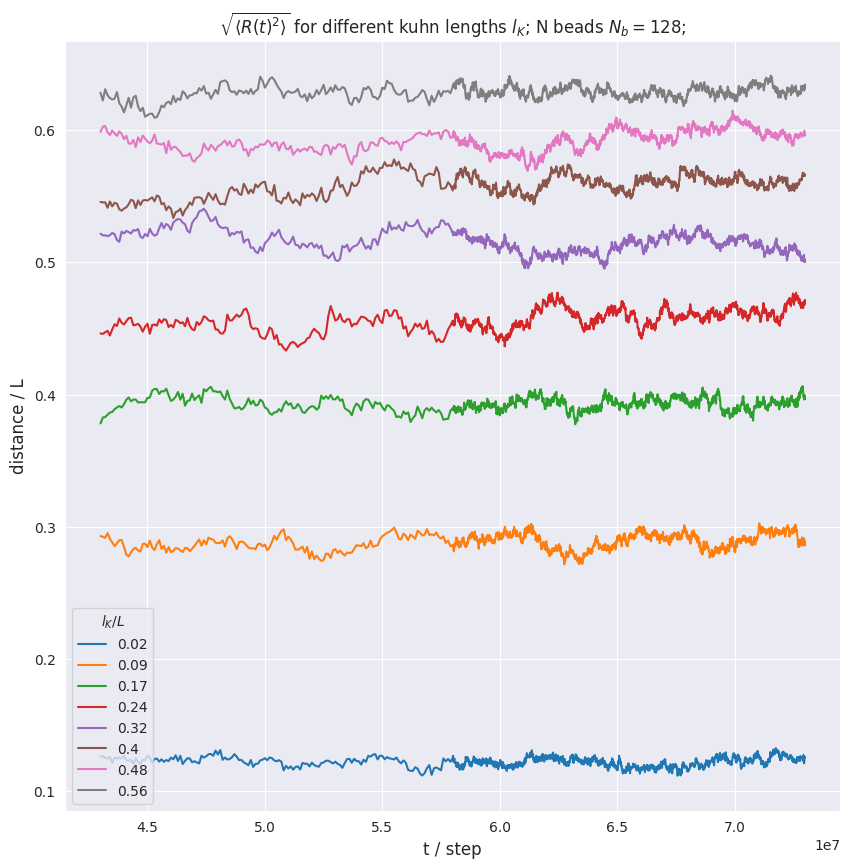

In [73]:
kappa_colors = sns.color_palette(n_colors=len(kappas))

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"]/L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Equilibrium statistics

In [74]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

58000000

In [75]:
df_trajectory_unfolded_kappas_equi = df_trajectory_unfolded_kappas.loc[df_trajectory_unfolded_kappas["t"] > t_equilibrium]
df_trajectory_unfolded_kappas_equi

,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
3891200,58010000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
3891201,58010000,2,1,-0.159927,-0.017451,-0.956566,0,0,0,1,1.0
3891202,58010000,3,2,-0.980909,-0.249781,-0.571110,0,0,0,1,1.0
3891203,58010000,4,2,-1.040590,-0.769522,-1.353570,0,0,0,1,1.0
3891204,58010000,5,2,-0.569420,-0.776283,-2.201200,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
338329595,73000000,25596,2,-10.385500,-62.418301,-40.259701,0,0,0,200,36.0
338329596,73000000,25597,2,-10.388300,-63.451401,-40.145500,0,0,0,200,36.0
338329597,73000000,25598,2,-10.585800,-64.320000,-39.889900,0,0,0,200,36.0
338329598,73000000,25599,2,-10.851100,-65.139801,-39.646099,0,0,0,200,36.0


In [76]:
df_ete_kappas_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_kappas_equi

R_x       R_y       R_z          R      t/LJ  \
kappa molecule-ID t                                                            
1.0   1           58000000  10.2626   9.39932   7.72573  15.917132  145000.0   
                  58010000  12.1361   9.42624   4.81479  16.103451  145025.0   
                  58020000  12.3665   9.79204   7.01795  17.264588  145050.0   
                  58030000  16.9066   7.06524   4.31075  18.823743  145075.0   
                  58040000  17.2395   2.07281   4.83280  18.023675  145100.0   
...                             ...       ...       ...        ...       ...   
36.0  200         72960000 -13.6698 -58.46460 -44.21120  74.562746  182400.0   
                  72970000 -17.0804 -61.24790 -46.43560  78.735699  182425.0   
                  72980000 -17.1194 -63.68640 -44.13480  79.353084  182450.0   
                  72990000 -18.5015 -62.81360 -44.44030  79.137817  182475.0   
                  73000000 -10.8909 -66.06510 -39.44010  77.709270  182500.0   

                                    R^2  
kappa molecule-ID t                      
1.0   1           58000000   253.355079  
                  58010000   259.321126  
                  58020000   298.065992  
                  58030000   354.333305  
                  58040000   324.852857  
...                                 ...  
36.0  200         72960000  5559.603091  
                  72970000  6199.310266  
                  72980000  6296.911972  
                  72990000  6262.794111  
                  73000000  6038.730629  

[2401600 rows x 6 columns]

In [77]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2        l_K
kappa t                               
1.0   58010000   244.191444   1.854017
      58020000   235.037652   1.854017
      58030000   227.478372   1.854017
      58040000   231.709597   1.854017
      58050000   230.876802   1.854017
...                     ...        ...
36.0  72960000  6020.383608  68.870000
      72970000  6055.454135  68.870000
      72980000  6043.288356  68.870000
      72990000  6055.318675  68.870000
      73000000  6108.701851  68.870000

[12000 rows x 2 columns]

### Mean bond length

In [78]:
if CHECK_BOND_LENGTHS:
    l_b_df = transform.extract_bond_lengths_df_kappas(df_trajectory_unfolded_kappas_equi, t_equilibrium=t_equilibrium)
    print(l_b_df.groupby("kappa").describe())

In [79]:
l_b = conf.initial_system_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [80]:
L_contour = l_b*(conf.initial_system_config.system_config.n_monomers-1)
L_contour

123.19

### Kuhn lengths

Svaneborg (8)

In [81]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([ 1.85401695, 10.67085829, 20.37000013, 30.07      , 39.77      ,
       49.47      , 59.17      , 68.87      ])

Estimate from fit (Worm-like chain model, Hinczewski):

In [86]:
l_ks_estimate = transform.estimate_kuhn_length_df(
    df_trajectory_unfolded_kappas_equi.loc[df_trajectory_unfolded_kappas_equi["t"] > 7e7],
    group_by_params=["kappa"],
    N_beads=conf.initial_system_config.system_config.n_monomers,
    l_b=l_b,
    n_processes=64
)
l_ks_estimate

,l_K,d_l_K
kappa,,
1.0,1.673012,0.001795
6.0,10.765192,0.011370
11.0,20.566056,0.023564
16.0,29.855544,0.037566
21.0,38.881755,0.057633
26.0,48.410560,0.046723
31.0,57.008547,0.080814
36.0,66.822848,0.062532


In [87]:
l_ks_estimate / L_contour

,l_K,d_l_K
kappa,,
1.0,0.013581,0.000015
6.0,0.087387,0.000092
11.0,0.166946,0.000191
16.0,0.242354,0.000305
21.0,0.315624,0.000468
26.0,0.392975,0.000379
31.0,0.462769,0.000656
36.0,0.542437,0.000508


Difference of analytical l_K and estimated l_K relative to analytical l_K

In [88]:
np.abs(l_ks - l_ks_estimate["l_K"]) / l_ks

kappa
1.0     0.097628
6.0     0.008840
11.0    0.009625
16.0    0.007132
21.0    0.022335
26.0    0.021416
31.0    0.036530
36.0    0.029725
Name: l_K, dtype: float64

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [68]:
N_Ks = (L_contour / l_ks)
N_Ks

array([0.16605166])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [69]:
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas

,R^2
kappa,
190.2,3354.509974


### Summarize statistics by kappas

In [70]:
df_kuhn_summary = pd.DataFrame({
    "R^2": df_ete_sq_t_mean_kappas["R^2"],
    "N_K": N_Ks,
    "l_K": l_ks
}, index=df_ete_sq_t_mean_kappas.index)
df_kuhn_summary

,R^2,N_K,l_K
kappa,,,
190.2,3354.509974,0.166052,368.018


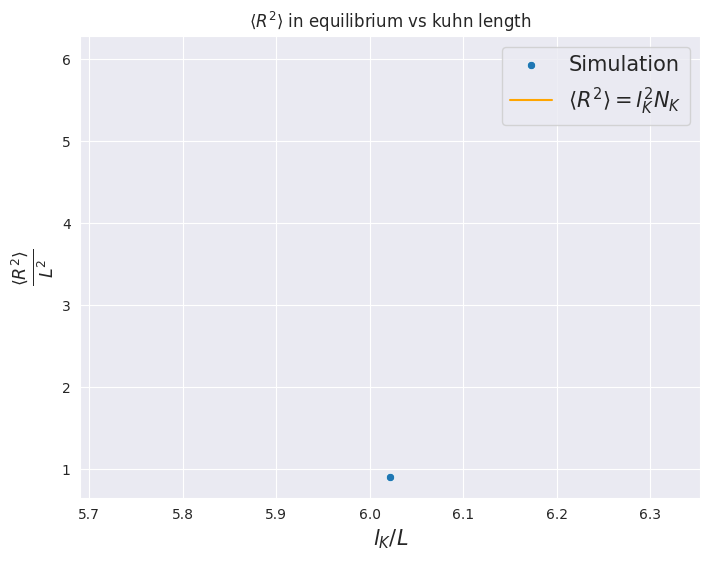

In [71]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=df_kuhn_summary["R^2"]/L_contour**2,
    ax=ax,
    label="Simulation"
)

sns.lineplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=(df_kuhn_summary["l_K"]**2 * N_Ks) / L_contour**2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange"
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)

ax.legend(fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [72]:
df_kuhn_summary["l_K"]**2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa
190.2    6.704282
dtype: float64

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [74]:
PATH_DF_MSD = PATH_DATA_PROCESSED / "msd.csv"
PATH_DF_MSD

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/12-EEA1_short-long_time/7ded95ff/data/processed/msd.csv')

In [85]:
if PATH_DF_MSD.exists():
    print("Reading processed ...")
    df_ete_change_kappas_equi = pd.read_csv(PATH_DF_MSD, index_col="t")
else:
    print("Processing ...")
    df_ete_change_kappas_equi = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_kappas_equi)
    df_ete_change_kappas_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_kappas_equi["kappa"], l_b=l_b)
    df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi.index.get_level_values("t").map(lambda t: t*0.0025)
    df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi["t/LJ"]-df_ete_change_kappas_equi["t/LJ"].min()
    df_ete_change_kappas_equi.to_csv(PATH_DF_MSD, index=True)

df_ete_change_kappas_equi

Processing ...


,dR^2,kappa,l_K,t/LJ
t,,,,
35000000,0.000000,190.2,368.018,0.0
35010000,20.286877,190.2,368.018,25.0
35020000,32.160526,190.2,368.018,50.0
35030000,34.070045,190.2,368.018,75.0
35040000,53.275140,190.2,368.018,100.0
...,...,...,...,...
534960000,1324.074449,190.2,368.018,1249900.0
534970000,1300.425401,190.2,368.018,1249925.0
534980000,1337.994253,190.2,368.018,1249950.0


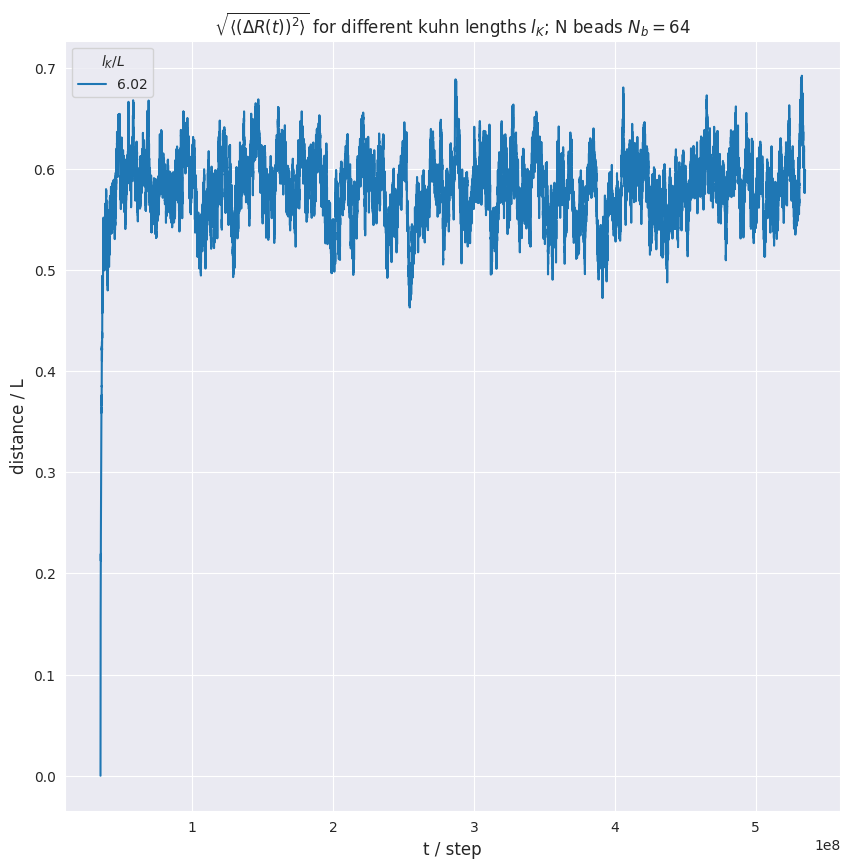

In [86]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_change_kappas_equi.index.get_level_values("t"),
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Compare with Grill

### Loglog scale

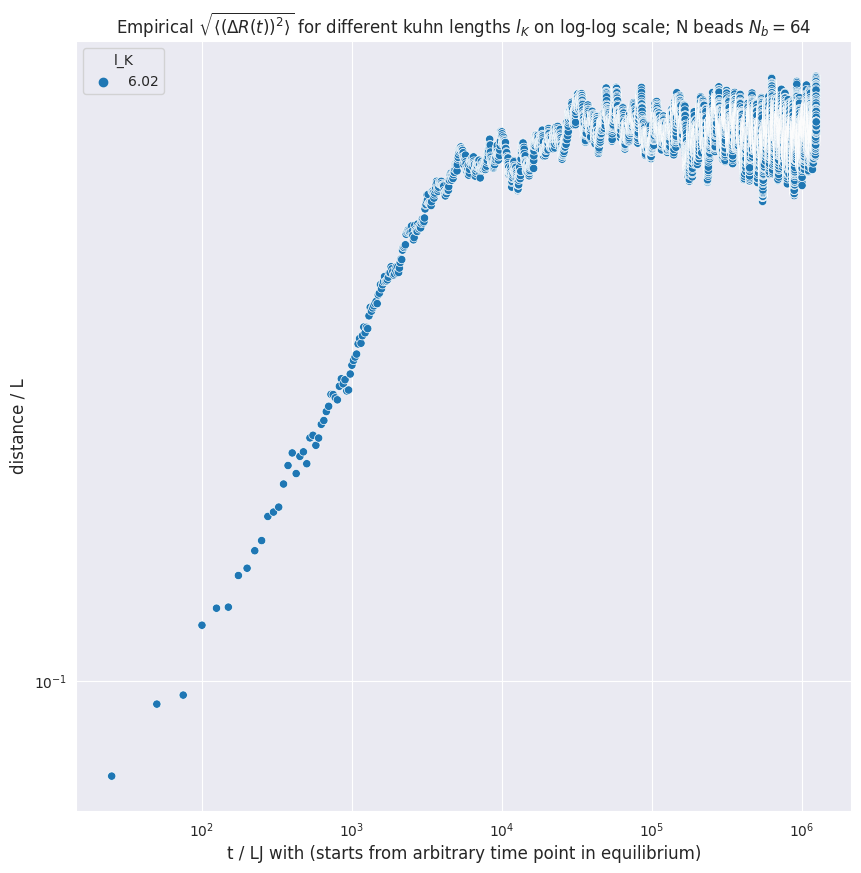

In [90]:
import matplotlib.ticker

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))

plot = sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

_ = ax.set(
    yscale="log",
    xscale="log",
    title=f'Empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$ on log-log scale; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)


## Compare with Rouse model


### Analytical $\tau_R$

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta_K N_K l_K^2}{k_B T} = \frac{1}{3 \pi^2} \frac{\zeta N_b N_K l_K^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{3 \pi^2 \tau_R}{N_K^2} $$

In [92]:
zeta = 1  # LJ
T = 1
k_B = 1
alpha = 4.047

rouse_times_analytical = []
for i, (l_K, N_K, R_sq) in enumerate(zip(df_kuhn_summary["l_K"], df_kuhn_summary["N_K"], df_kuhn_summary["R^2"])):
    tau_R_analytical = zeta*conf.initial_system_config.system_config.n_monomers*N_K*l_K**2 / (3*np.pi**2*k_B*T)
    tau_R_analytical_corrected = tau_R_analytical*alpha
    rouse_times_analytical.append(tau_R_analytical_corrected)

df_rouse_times_theory = pd.DataFrame({
    "l_K": df_kuhn_summary["l_K"],
    "N_K": df_kuhn_summary["N_K"],
    "Theory tau_R": rouse_times_analytical,
    "Theory tau_0": rouse_times_analytical / df_kuhn_summary["N_K"]**2
}, index=df_kuhn_summary.index)

df_rouse_times_theory

,l_K,N_K,Theory tau_R,Theory tau_0
kappa,,,,
190.2,368.018,0.166052,196731.327645,7.134887e+06


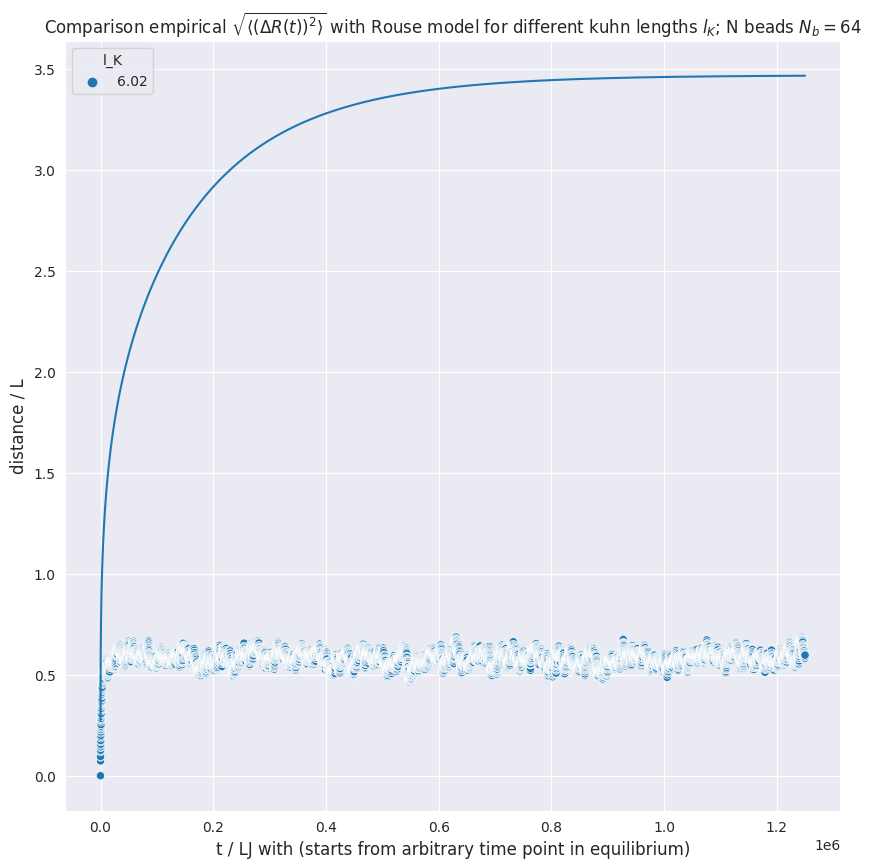

In [94]:
import matplotlib.legend

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'Comparison empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ with Rouse model for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

plot = sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

lines = []
labels = []

for i, (l_K, N_K, tau_R) in enumerate(zip(df_rouse_times_theory["l_K"], df_rouse_times_theory["N_K"], df_rouse_times_theory["Theory tau_R"])):
    ts = df_ete_change_kappas_equi["t/LJ"].unique()

    rouse_predictions = rouse.rouse_g_4(
        t=ts,
        tau_R=tau_R,
        p_max=conf.initial_system_config.system_config.n_monomers,
        N_b=N_K,
        l_b=l_K
    )
    line = ax.plot(
        ts,
        np.sqrt(rouse_predictions) / L_contour,
        color=kappa_colors[i]
    )
    lines.append(line)
    labels.append(f"$\sqrt{{g_4(t)}}$ for $l_K/L = {np.round(l_K/L_contour, 2)}$")

### Fit $\tau_R$

In [106]:

df_rouse_times_fit = []

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4, N_b=N_K, l_b=l_K, p_max=conf.initial_system_config.system_config.n_monomers),
        df_ete_change_kappas_equi_kappa.loc[df_ete_change_kappas_equi_kappa["t/LJ"]<1e4]["t/LJ"],
        df_ete_change_kappas_equi_kappa[df_ete_change_kappas_equi_kappa["t/LJ"]<1e4]["dR^2"],
        p0=(10**(i+1),) if i!=0 else 100
    )
    df_rouse_times_fit.append((kappa, popt[0], np.sqrt(np.diag(pcov))[0], l_K, N_K))

df_rouse_times_fit = pd.DataFrame(
    df_rouse_times_fit,
    columns=["kappa", "Empirical tau_R", "Empirical Delta tau_R", "l_K", "N_K"]
).set_index("kappa")

df_rouse_times_fit["Empirical tau_0"] = df_rouse_times_fit["Empirical tau_R"] / df_rouse_times_fit["N_K"]**2
df_rouse_times_fit["Empirical Delta tau_0"] = df_rouse_times_fit["Empirical Delta tau_R"] / df_rouse_times_fit["N_K"]**2

df_rouse_times_fit

,Empirical tau_R,Empirical Delta tau_R,l_K,N_K,Empirical tau_0,Empirical Delta tau_0
kappa,,,,,,
190.2,6.864633e+06,89815.05141,368.018,0.166052,2.489607e+08,3.257337e+06


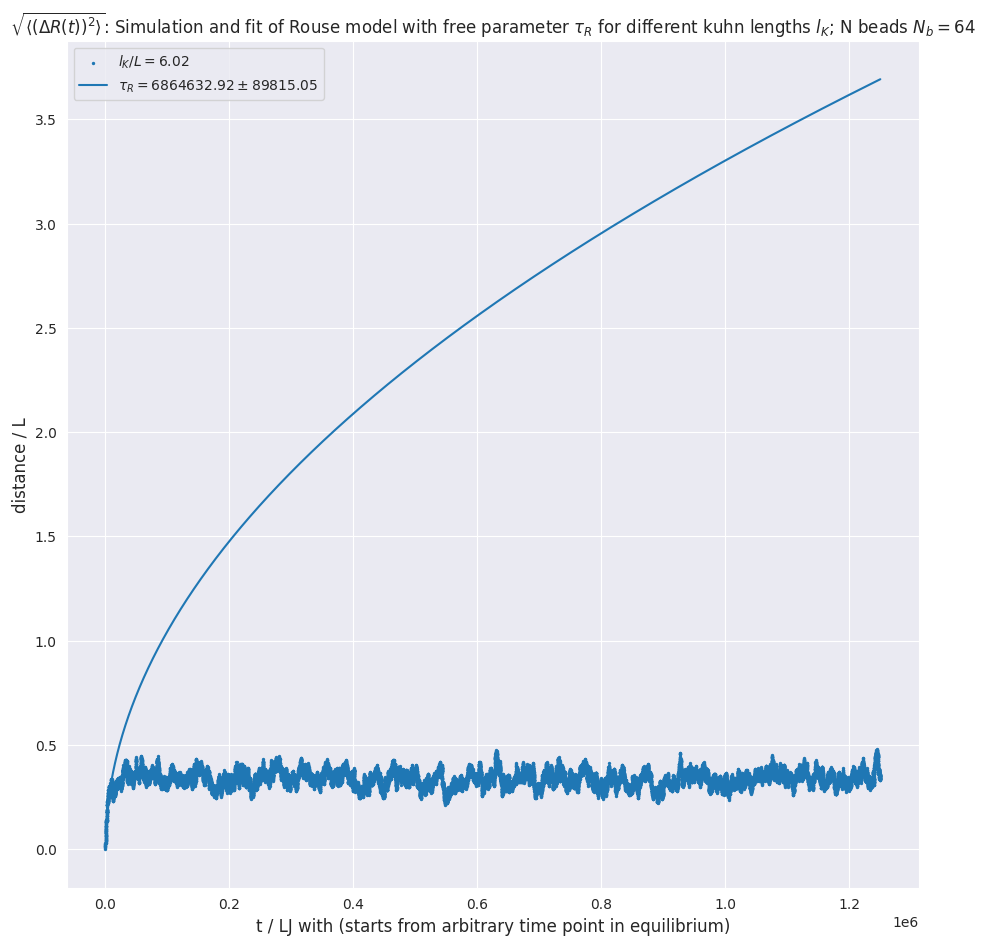

In [107]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(11,11))

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    ax.scatter(
        df_ete_change_kappas_equi_kappa["t/LJ"],
        df_ete_change_kappas_equi_kappa["dR^2"] / L_contour**2,
        label=f"$l_K/L={np.round(l_K/L_contour, 2)}$",
        #marker= list(matplotlib.markers.MarkerStyle.markers.keys())[i],
        color=kappa_colors[i],
        s=2
    )
    ax.plot(
        df_ete_change_kappas_equi_kappa["t/LJ"],
        rouse.rouse_g_4(
            t=df_ete_change_kappas_equi_kappa["t/LJ"],
            N_b=N_K,
            l_b=l_K,
            p_max=conf.initial_system_config.system_config.n_monomers,
            tau_R=tau_R
        ) / L_contour**2,
        label=f"$\\tau_R={tau_R:.2f} \pm {dtau_R:.2f}$",
        color=kappa_colors[i]
    )

ax.legend()

_ = ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

### Compare times

In [108]:
df_rouse_rimes = df_rouse_times_theory.join(df_rouse_times_fit.drop(["l_K", "N_K"], axis=1))
df_rouse_rimes

,l_K,N_K,Theory tau_R,Theory tau_0,Empirical tau_R,Empirical Delta tau_R,Empirical tau_0,Empirical Delta tau_0
kappa,,,,,,,,
190.2,368.018,0.166052,196731.327645,7.134887e+06,6.864633e+06,89815.05141,2.489607e+08,3.257337e+06


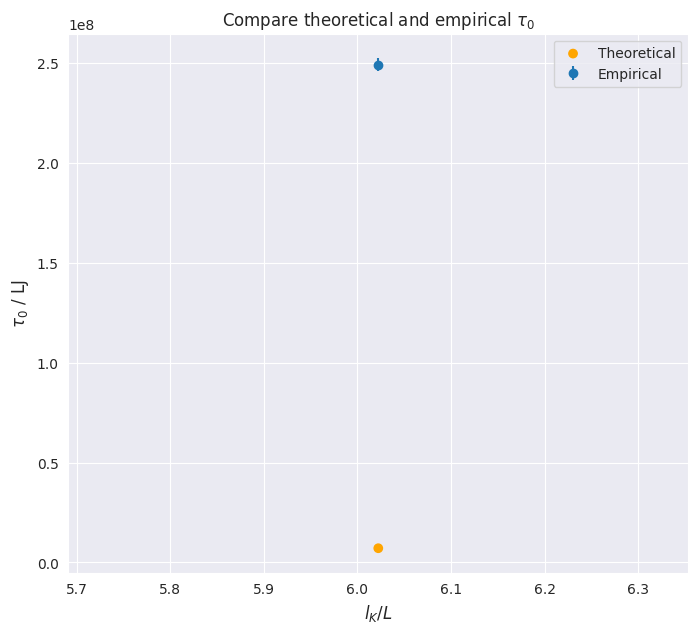

In [109]:
import matplotlib.container
import matplotlib.collections

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8,7))

errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\tau_0$ / LJ",
    title="Compare theoretical and empirical $\\tau_0$"
)

path_coll: matplotlib.collections.PathCollection = ax.scatter(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Theory tau_0"],
    linestyle="",
    marker="o",
    label="Theoretical",
    color="orange",
)

ax.legend()

[Text(0.5, 0, '$l_K/L$'),
 Text(0, 0.5, '$\\Delta \\tau_0$ / LJ'),
 Text(0.5, 1.0, 'Empirical $\\tau_0$ - Theoretical $\\tau_0$')]

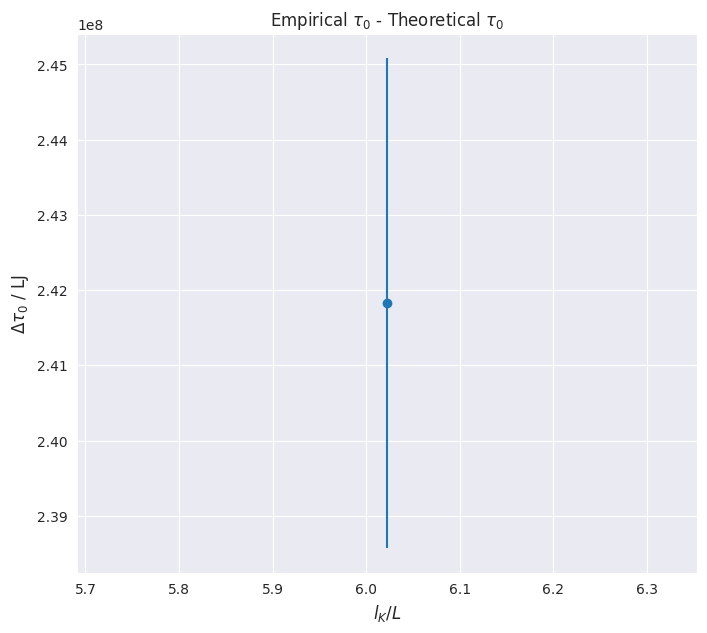

In [110]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8,7))


errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"] - df_rouse_rimes["Theory tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical - Theory",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\Delta \\tau_0$ / LJ",
    title="Empirical $\\tau_0$ - Theoretical $\\tau_0$"
)